<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Advanced Time Series Analysis</h1>
<h1>statsmodels for Time Series</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt 

import scipy
from scipy.stats import pearsonr

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

pandas          1.0.1
numpy           1.18.1
watermark       2.0.2
matplotlib      3.1.3
statsmodels.api 0.11.1
autopep8        1.5
json            2.0.9
scipy           1.4.1
Wed Aug 12 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ad113ebccef84746db0546ef024c357d7cba54ca


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Linear Regression

Let us load up one of the datasets from the Anscombe quartet

In [4]:
data = pd.read_csv('data/Anscombe1.dat', sep=' ', header=None)
data.columns = ['x1', 'y']

And make a quick plot

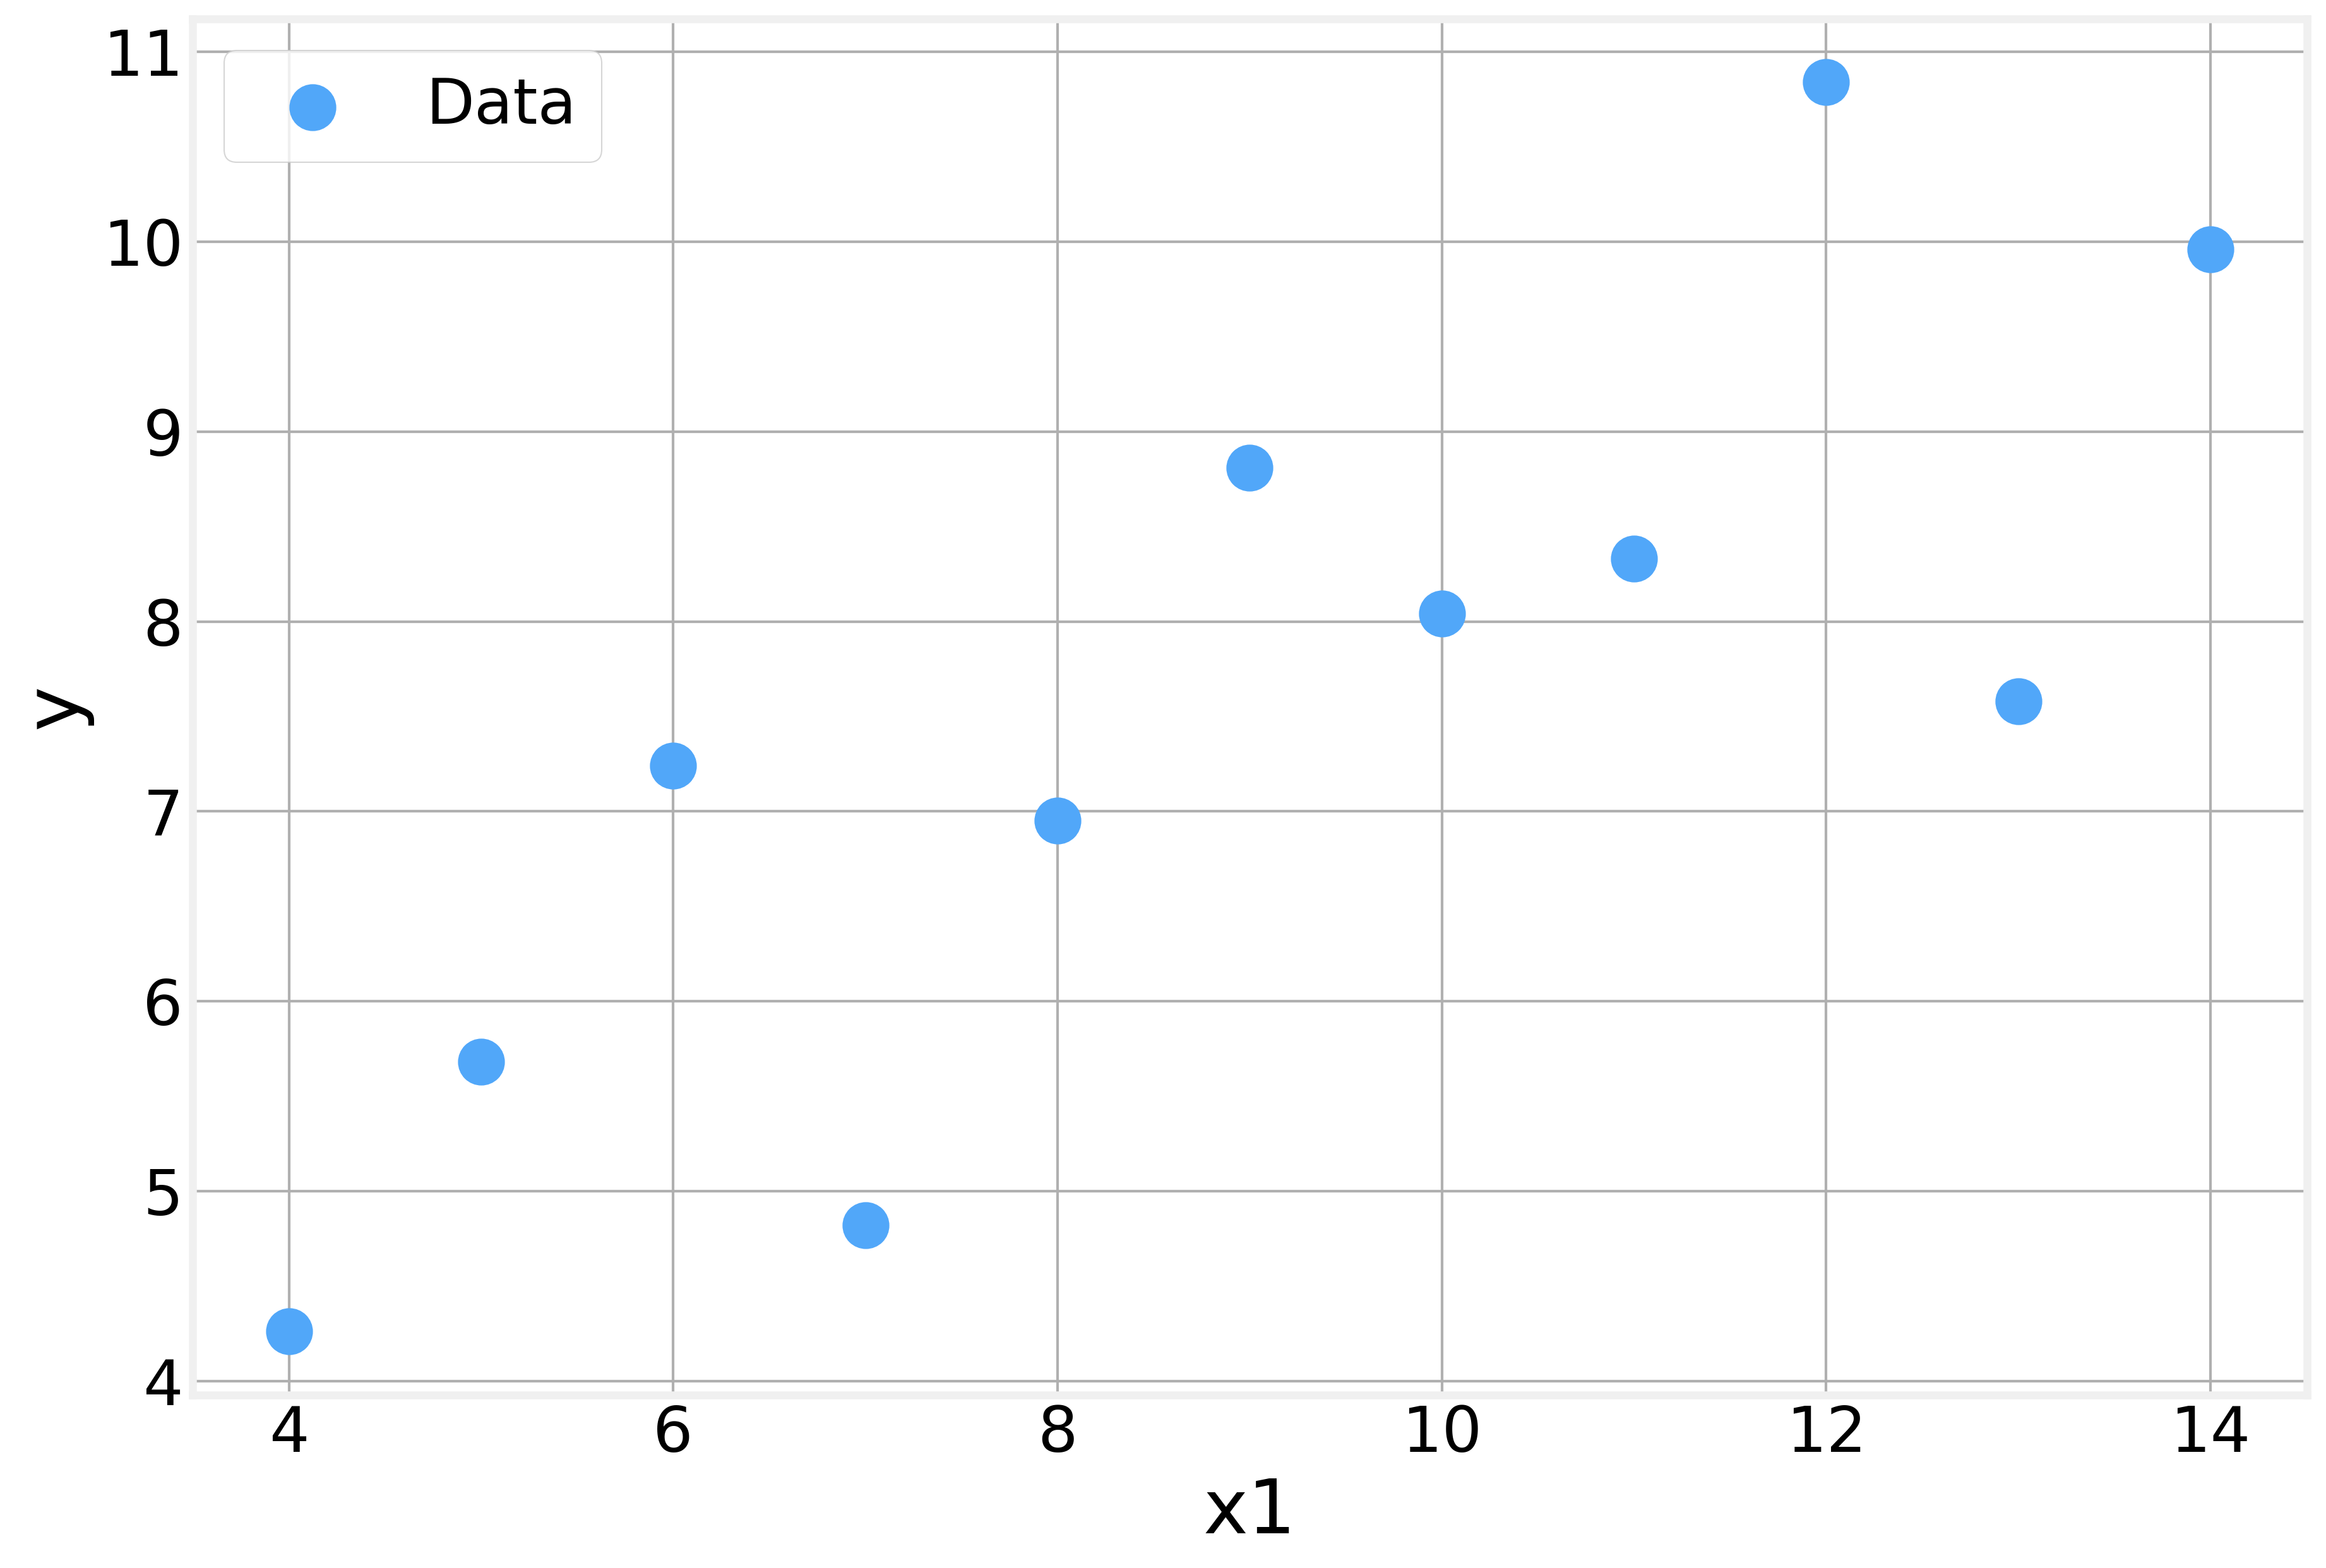

In [5]:
ax = data.plot(x='x1', y='y', kind='scatter', s=300)
ax.legend(['Data'], loc='upper left')

We'll use __statsmodels__ to perform a quick OLS to perform a Linear Regression fit. While we won't be using Linear Regressions explicitly in this lecture, many time series analysis algorithms rely on it so we include it for ease of reference. We start by explicitly adding a column of 1s for the intercept

In [6]:
data['const'] = 1

Perform the fit

In [7]:
model = sm.OLS(endog=data['y'], exog=data[['const', 'x1']])
results = model.fit()

And get a summary table of the results

In [8]:
results.summary()

/Users/bgoncalves/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     17.99
Date:                Wed, 12 Aug 2020   Prob (F-statistic):            0.00217
Time:                        07:37:48   Log-Likelihood:                -16.841
No. Observations:                  11   AIC:                             37.68
Df Residuals:                       9   BIC:                             38.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0001      1.125      2.667      0.026       0.456       5.544
x1             0.5001      0.118      4.241      0.002       0.233       0.767
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   3.212
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.289
Skew:                          -0.122   Prob(JB):                        0.865
Kurtosis:                       2.244   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And calculate the model prediction for each point

In [9]:
Y1 = results.predict(data[['const', 'x1']])

And finally plot the fitted line:

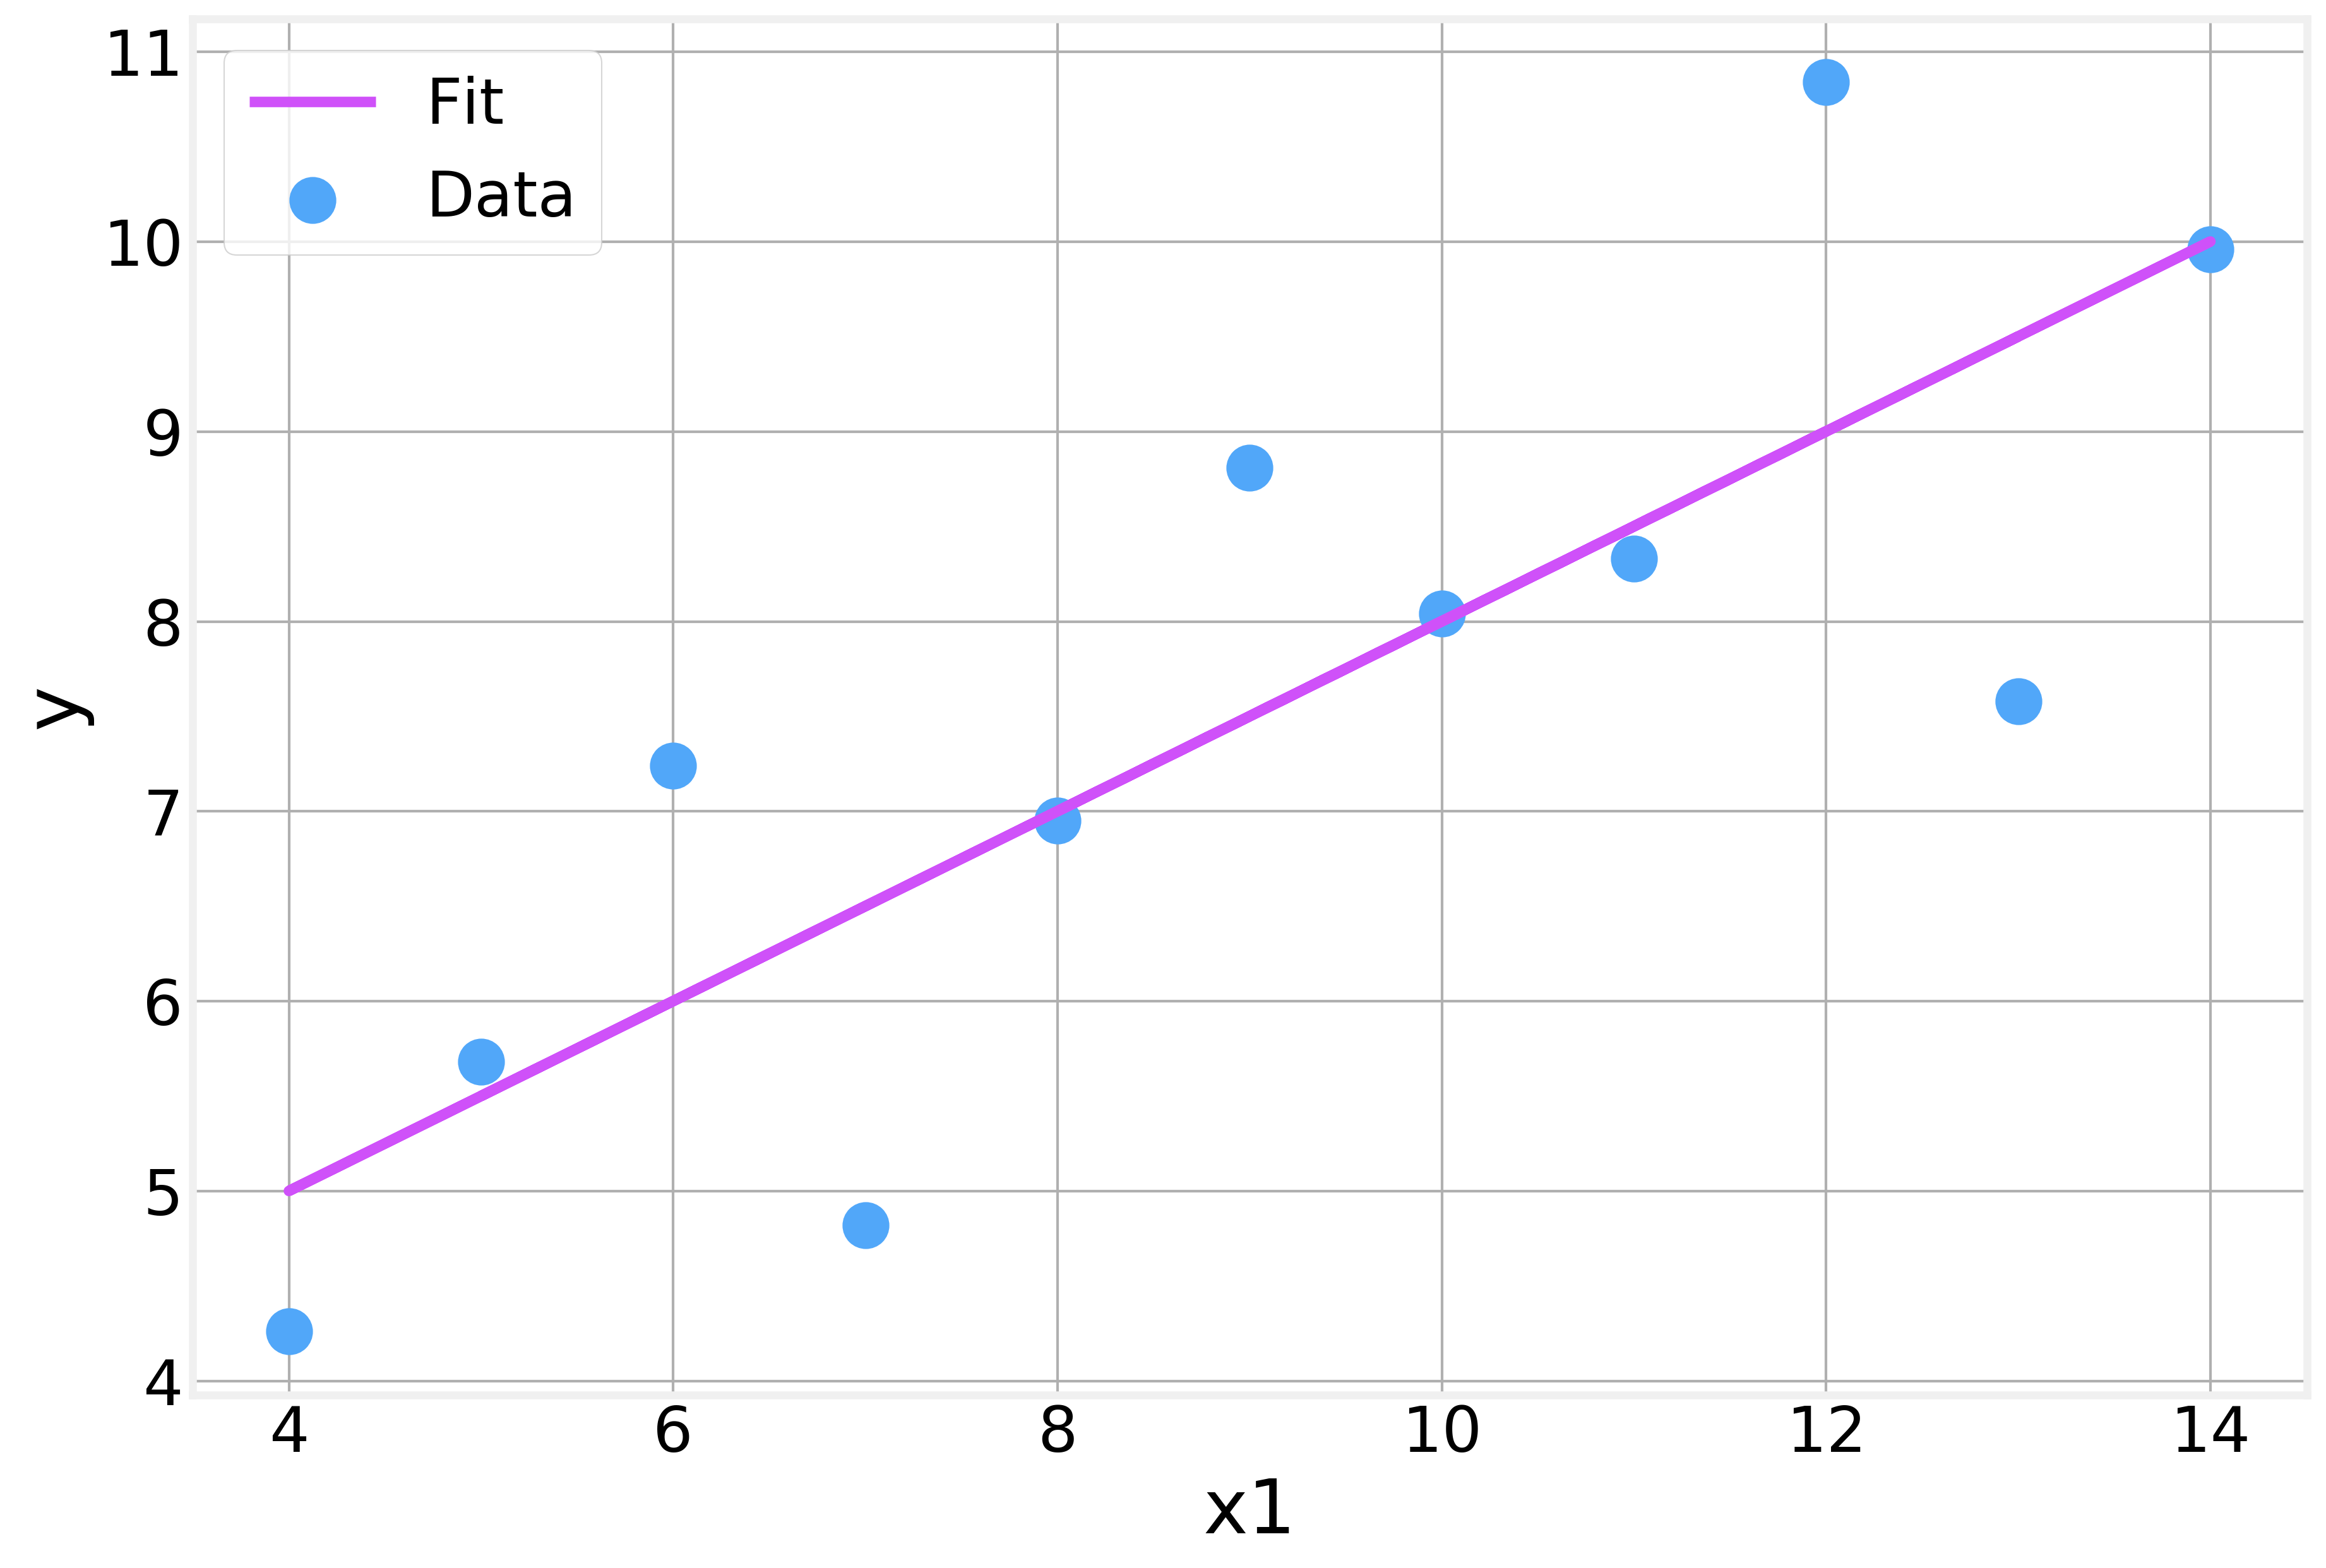

In [10]:
ax = data.plot(x='x1', y='y', kind='scatter', s=300)
ax.plot(data['x1'], Y1, color=colors[1])
ax.legend(['Fit', 'Data'])

## Correlations

Let's load a time series to take as an example. We'll use the time series of sunspot activity

In [11]:
Sun = pd.read_csv('data/sun.csv')

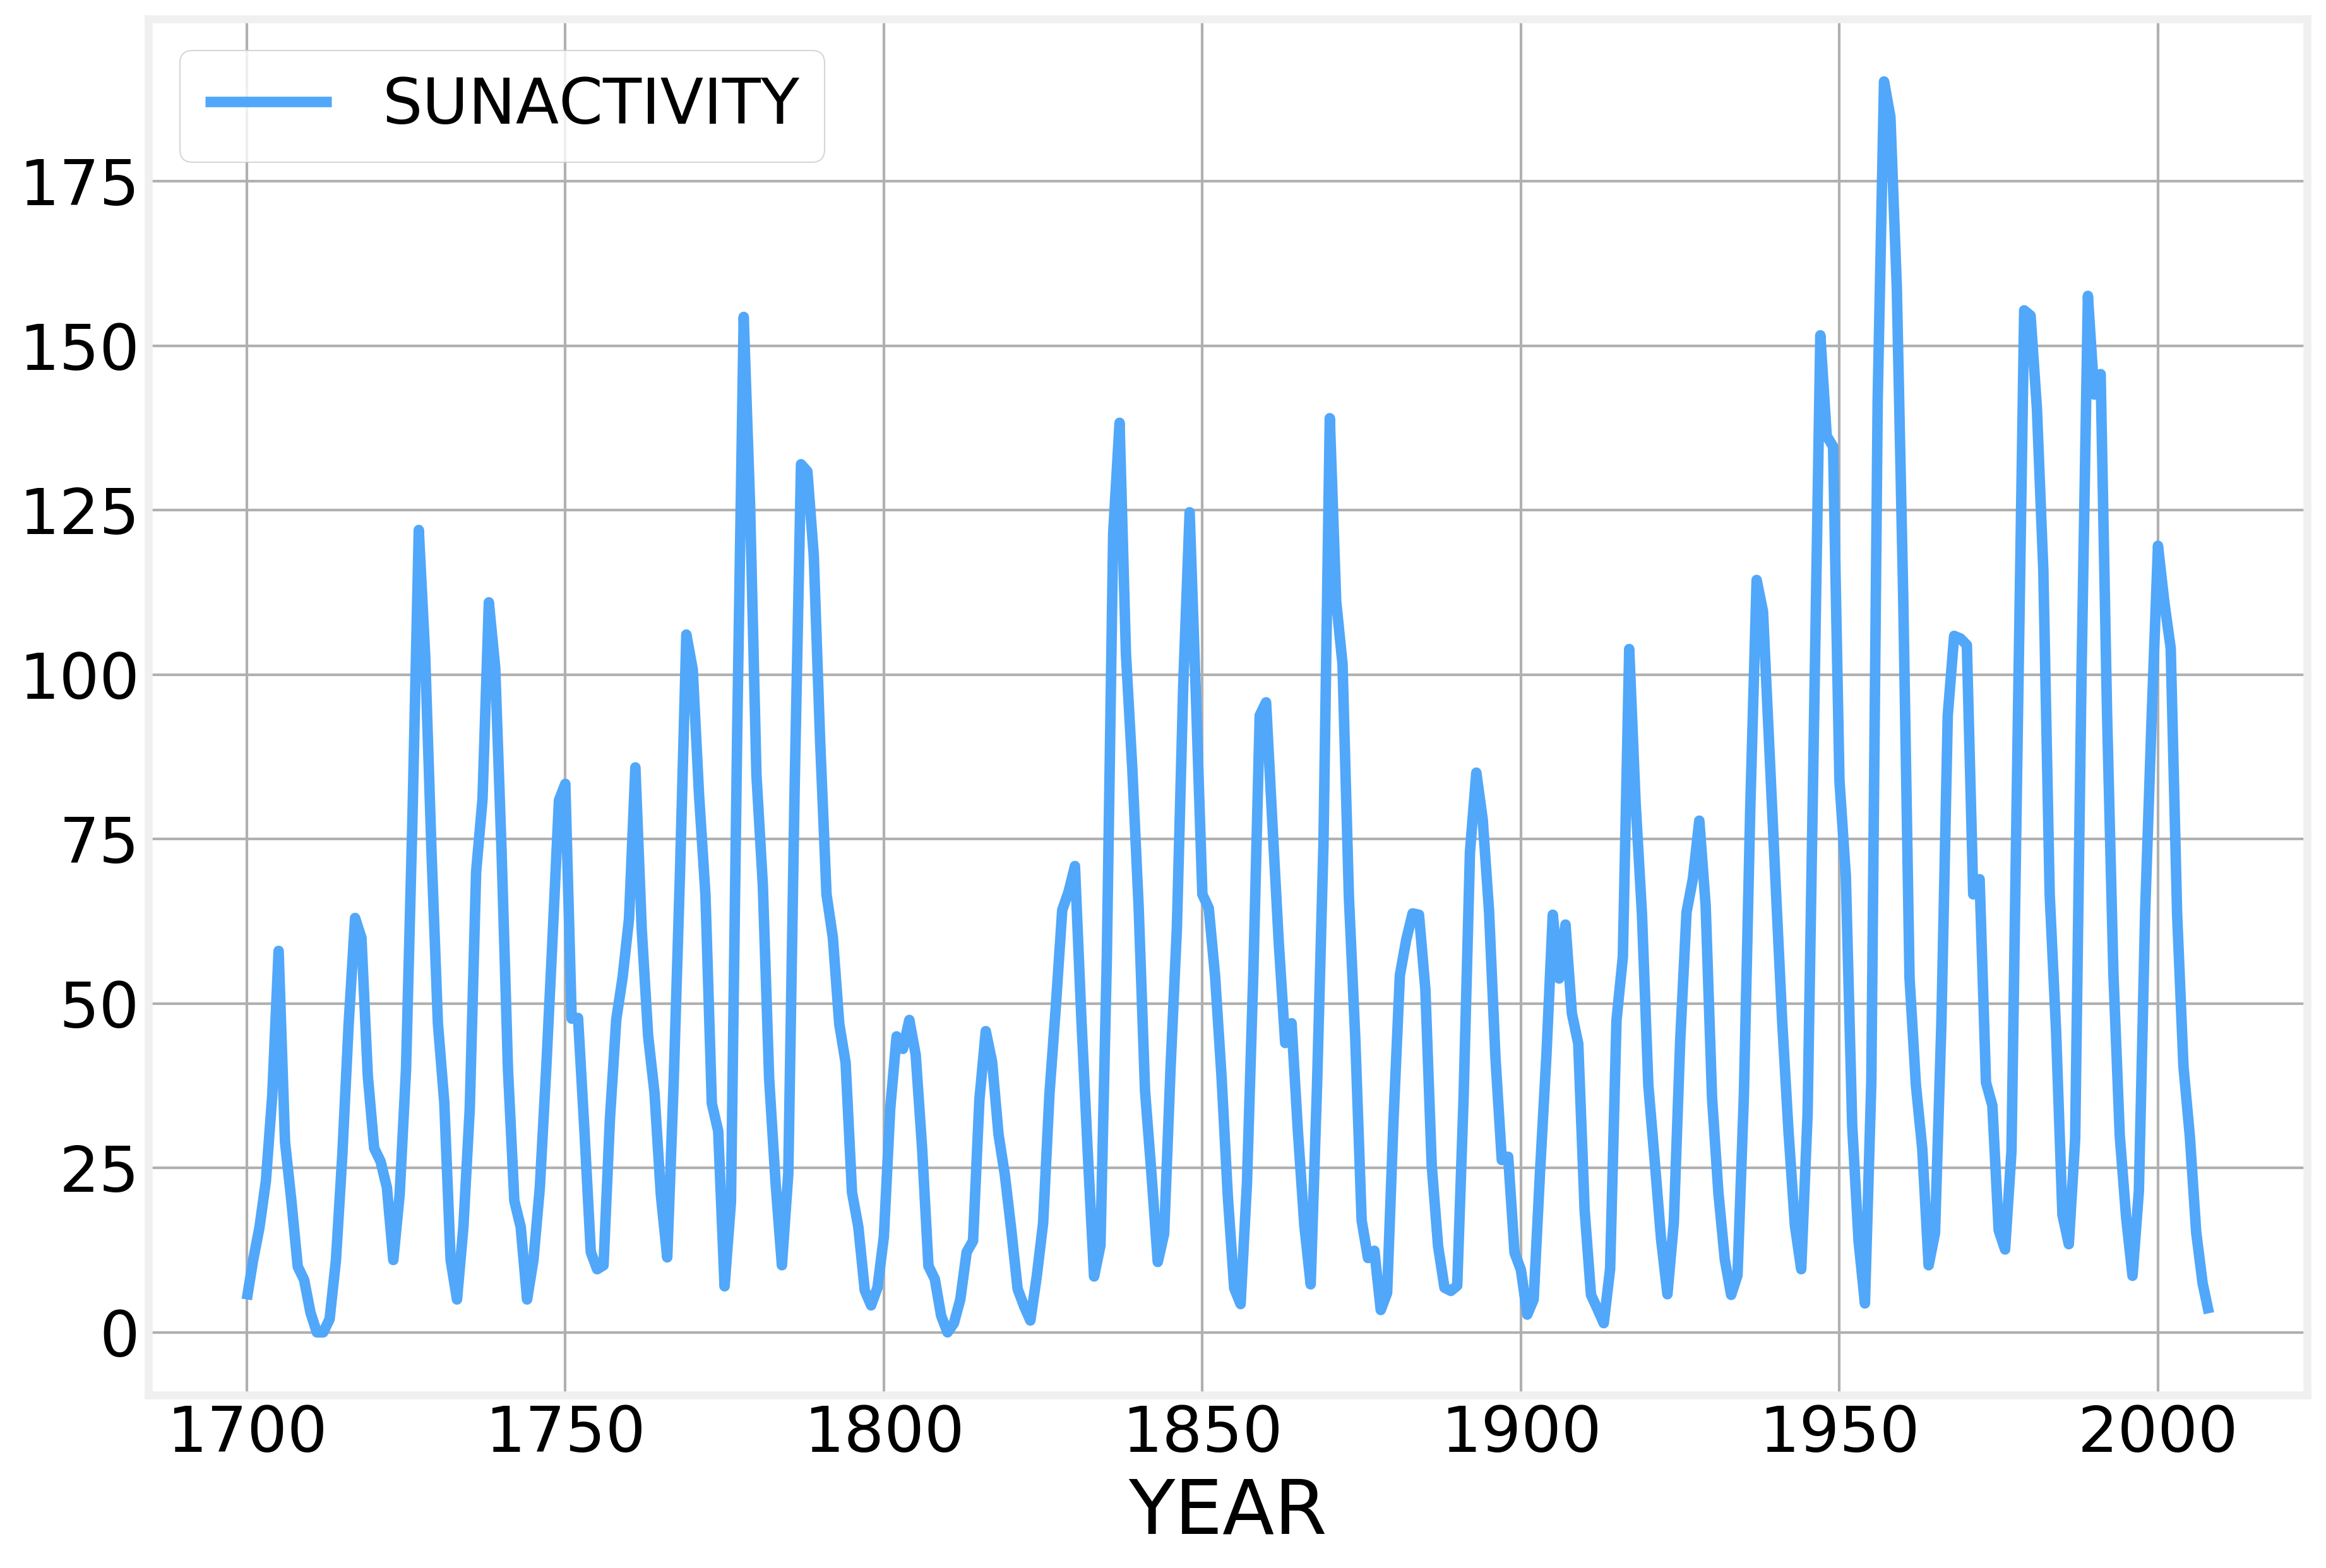

In [12]:
Sun.set_index('YEAR').plot()

In [13]:
sm.tsa.stattools.acf(Sun['SUNACTIVITY'])

/Users/bgoncalves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([ 1.        ,  0.82020129,  0.45126849,  0.03957655, -0.27579196,
       -0.42523943, -0.37659509, -0.15737391,  0.15820254,  0.47309753,
        0.65898002,  0.65029082,  0.45666254,  0.16179329, -0.12205105,
       -0.3161808 , -0.37471125, -0.30605753, -0.1348069 ,  0.09158727,
        0.2975632 ,  0.4207074 ,  0.41183954,  0.27020758,  0.04496208,
       -0.17428715, -0.33045026, -0.37287834, -0.28555061, -0.11794414,
        0.08293231,  0.24897507,  0.32752101,  0.28335919,  0.1375272 ,
       -0.05526386, -0.22973205, -0.31338879, -0.29355684, -0.17897285,
       -0.01769038])

Due to a small issue with the way statsmodels interacts with jupyter, we terminate the line with a semi-colon (or assign the output to a variable) in order to prevent double plotting.

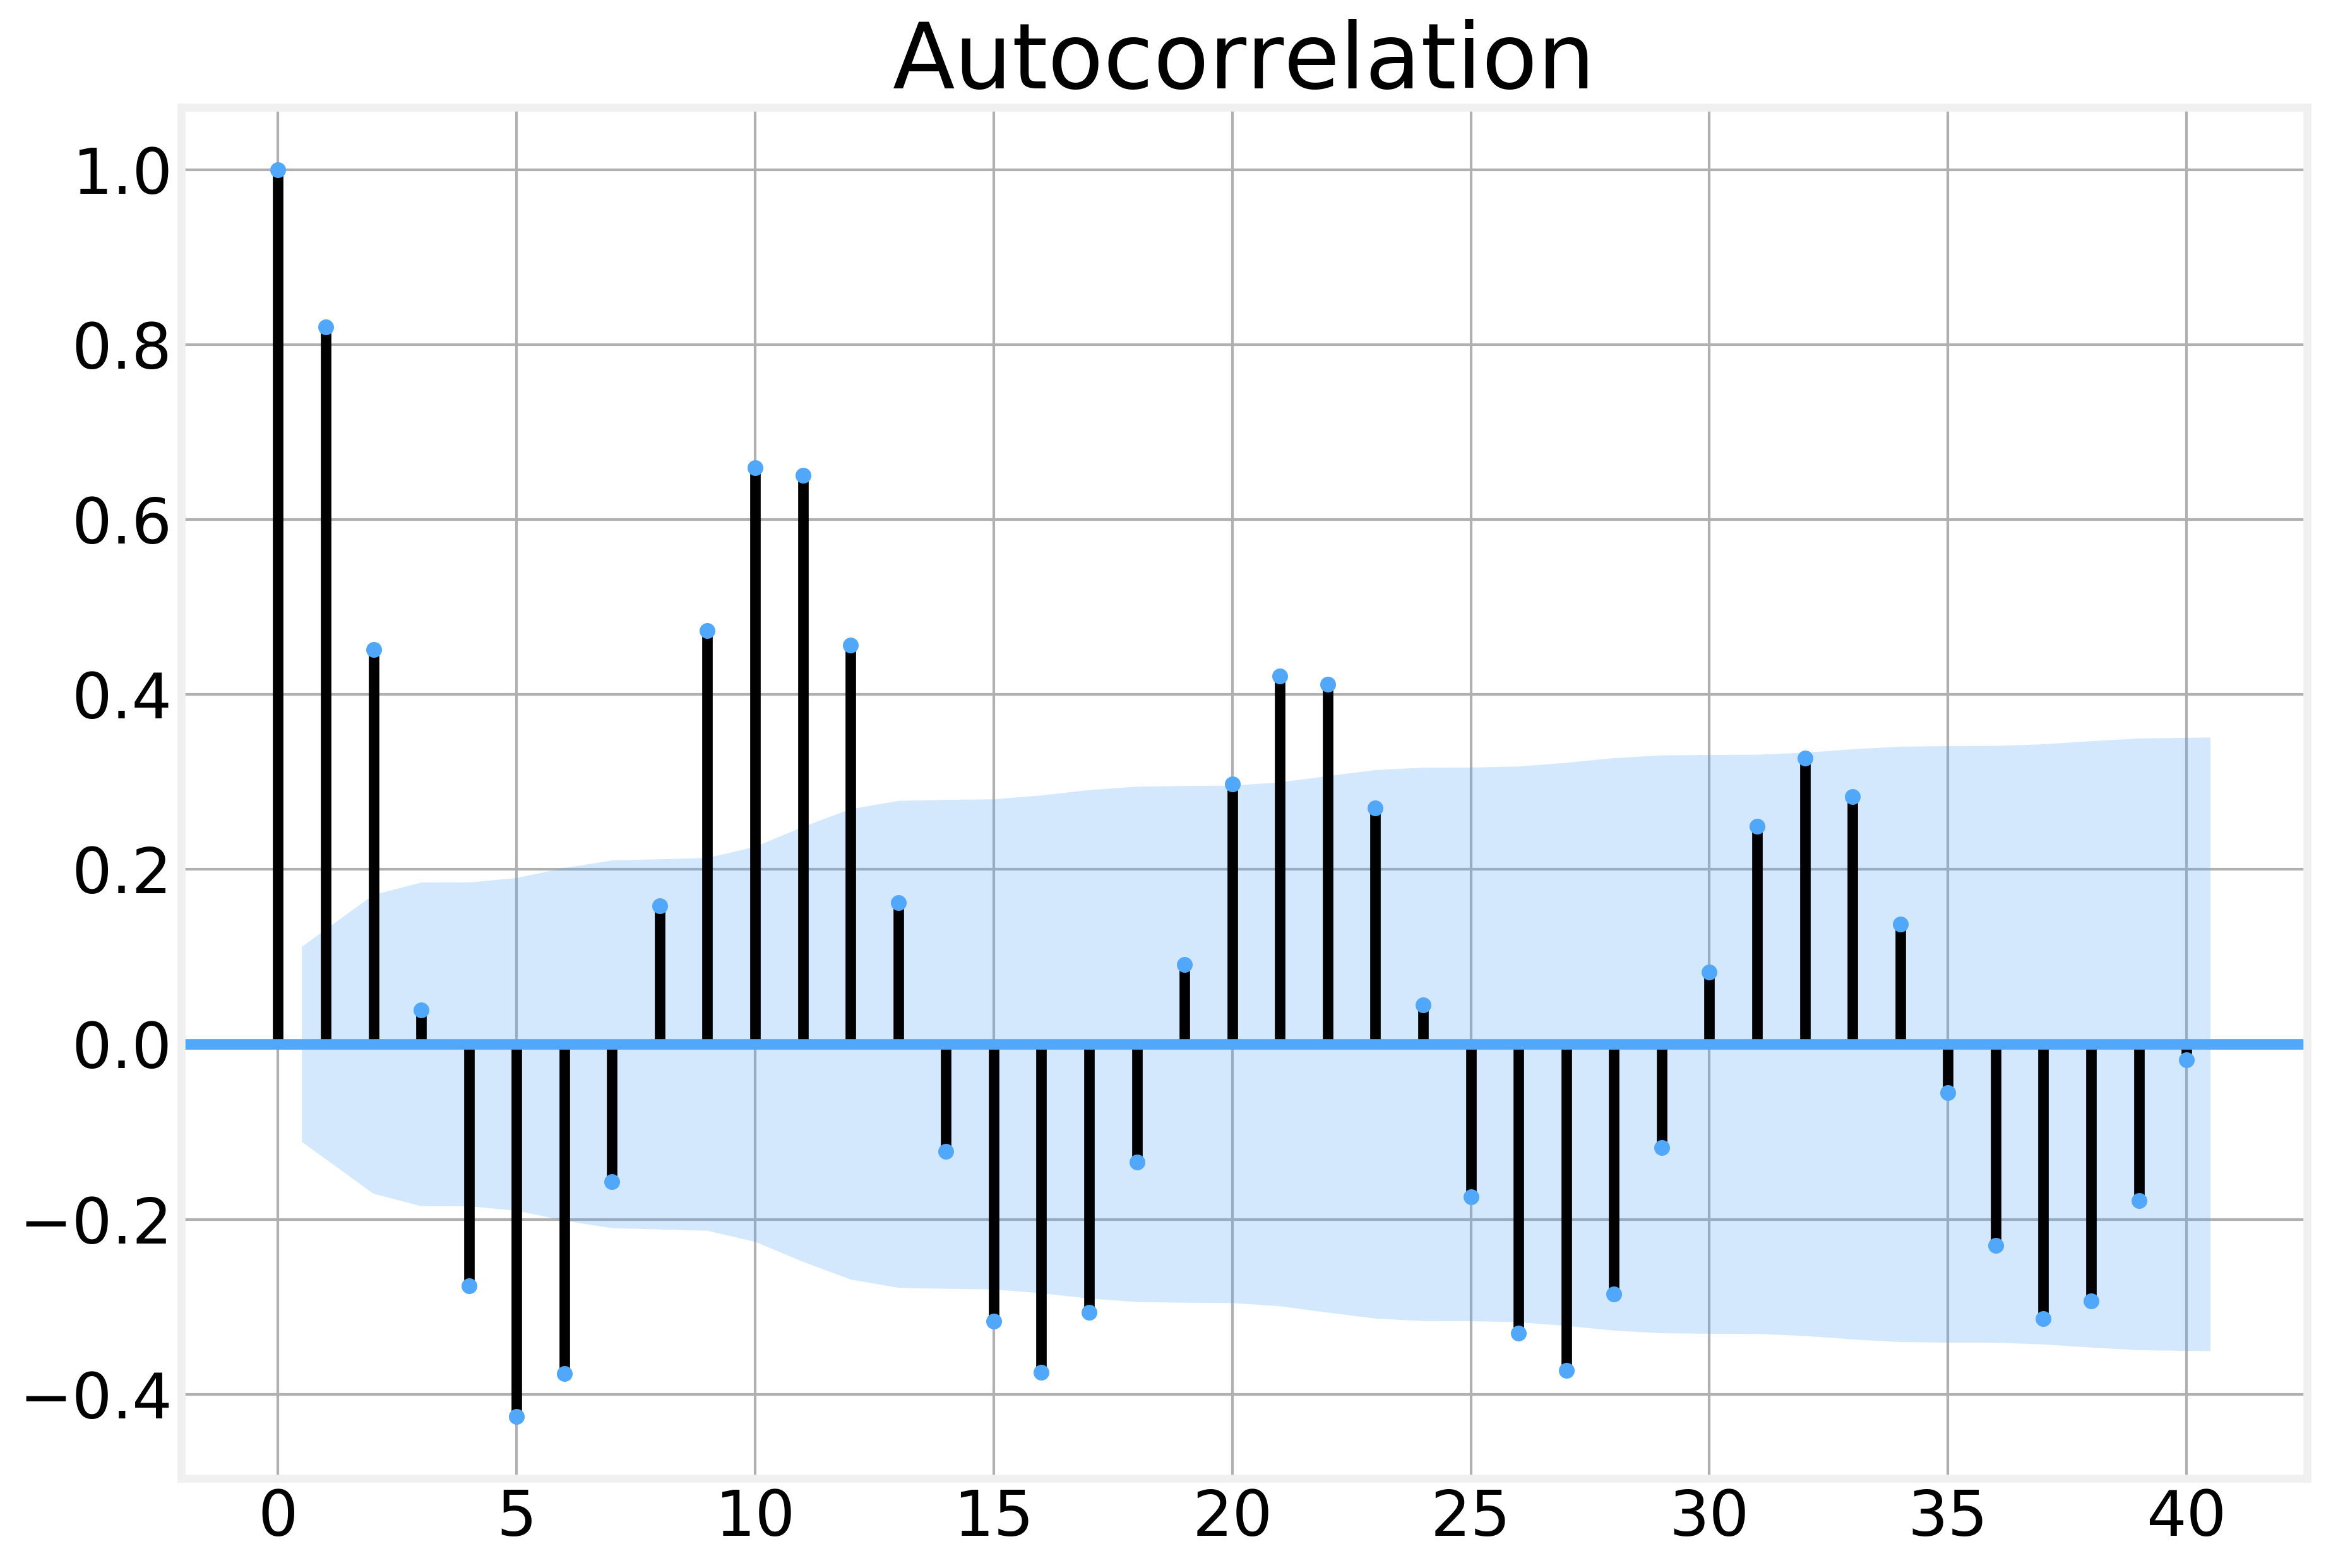

In [14]:
sm.graphics.tsa.plot_acf(Sun['SUNACTIVITY'], lags=40);

The corresponding partial-autocorrelation functions work in similar ways:

In [15]:
sm.tsa.stattools.pacf(Sun['SUNACTIVITY'])

array([ 1.00000000e+00,  8.22864286e-01, -6.90310216e-01, -1.40572128e-01,
        5.60804025e-02,  4.90077270e-03,  1.82247989e-01,  2.19939368e-01,
        2.28436387e-01,  2.62692745e-01, -1.64957719e-02, -7.62590556e-03,
       -1.50968950e-02, -8.28648718e-04,  6.16072896e-02, -8.27061703e-02,
       -7.88015856e-02, -1.62447551e-01, -9.12918340e-02,  4.47916043e-02,
        2.45683035e-03,  1.12617329e-01, -1.31318378e-03, -9.92893352e-02,
       -5.70561869e-02,  2.29911661e-02, -6.61542747e-02,  9.74598824e-02,
        1.11323622e-01, -1.26321199e-01,  2.49774293e-02, -4.76464467e-02,
       -1.07618291e-02,  5.20777678e-03,  9.02935874e-03,  2.03912400e-02,
       -4.84266992e-02,  6.88517686e-02, -4.06046146e-02,  4.47681852e-02,
        4.77286574e-02])

As before, we include the semi-colon

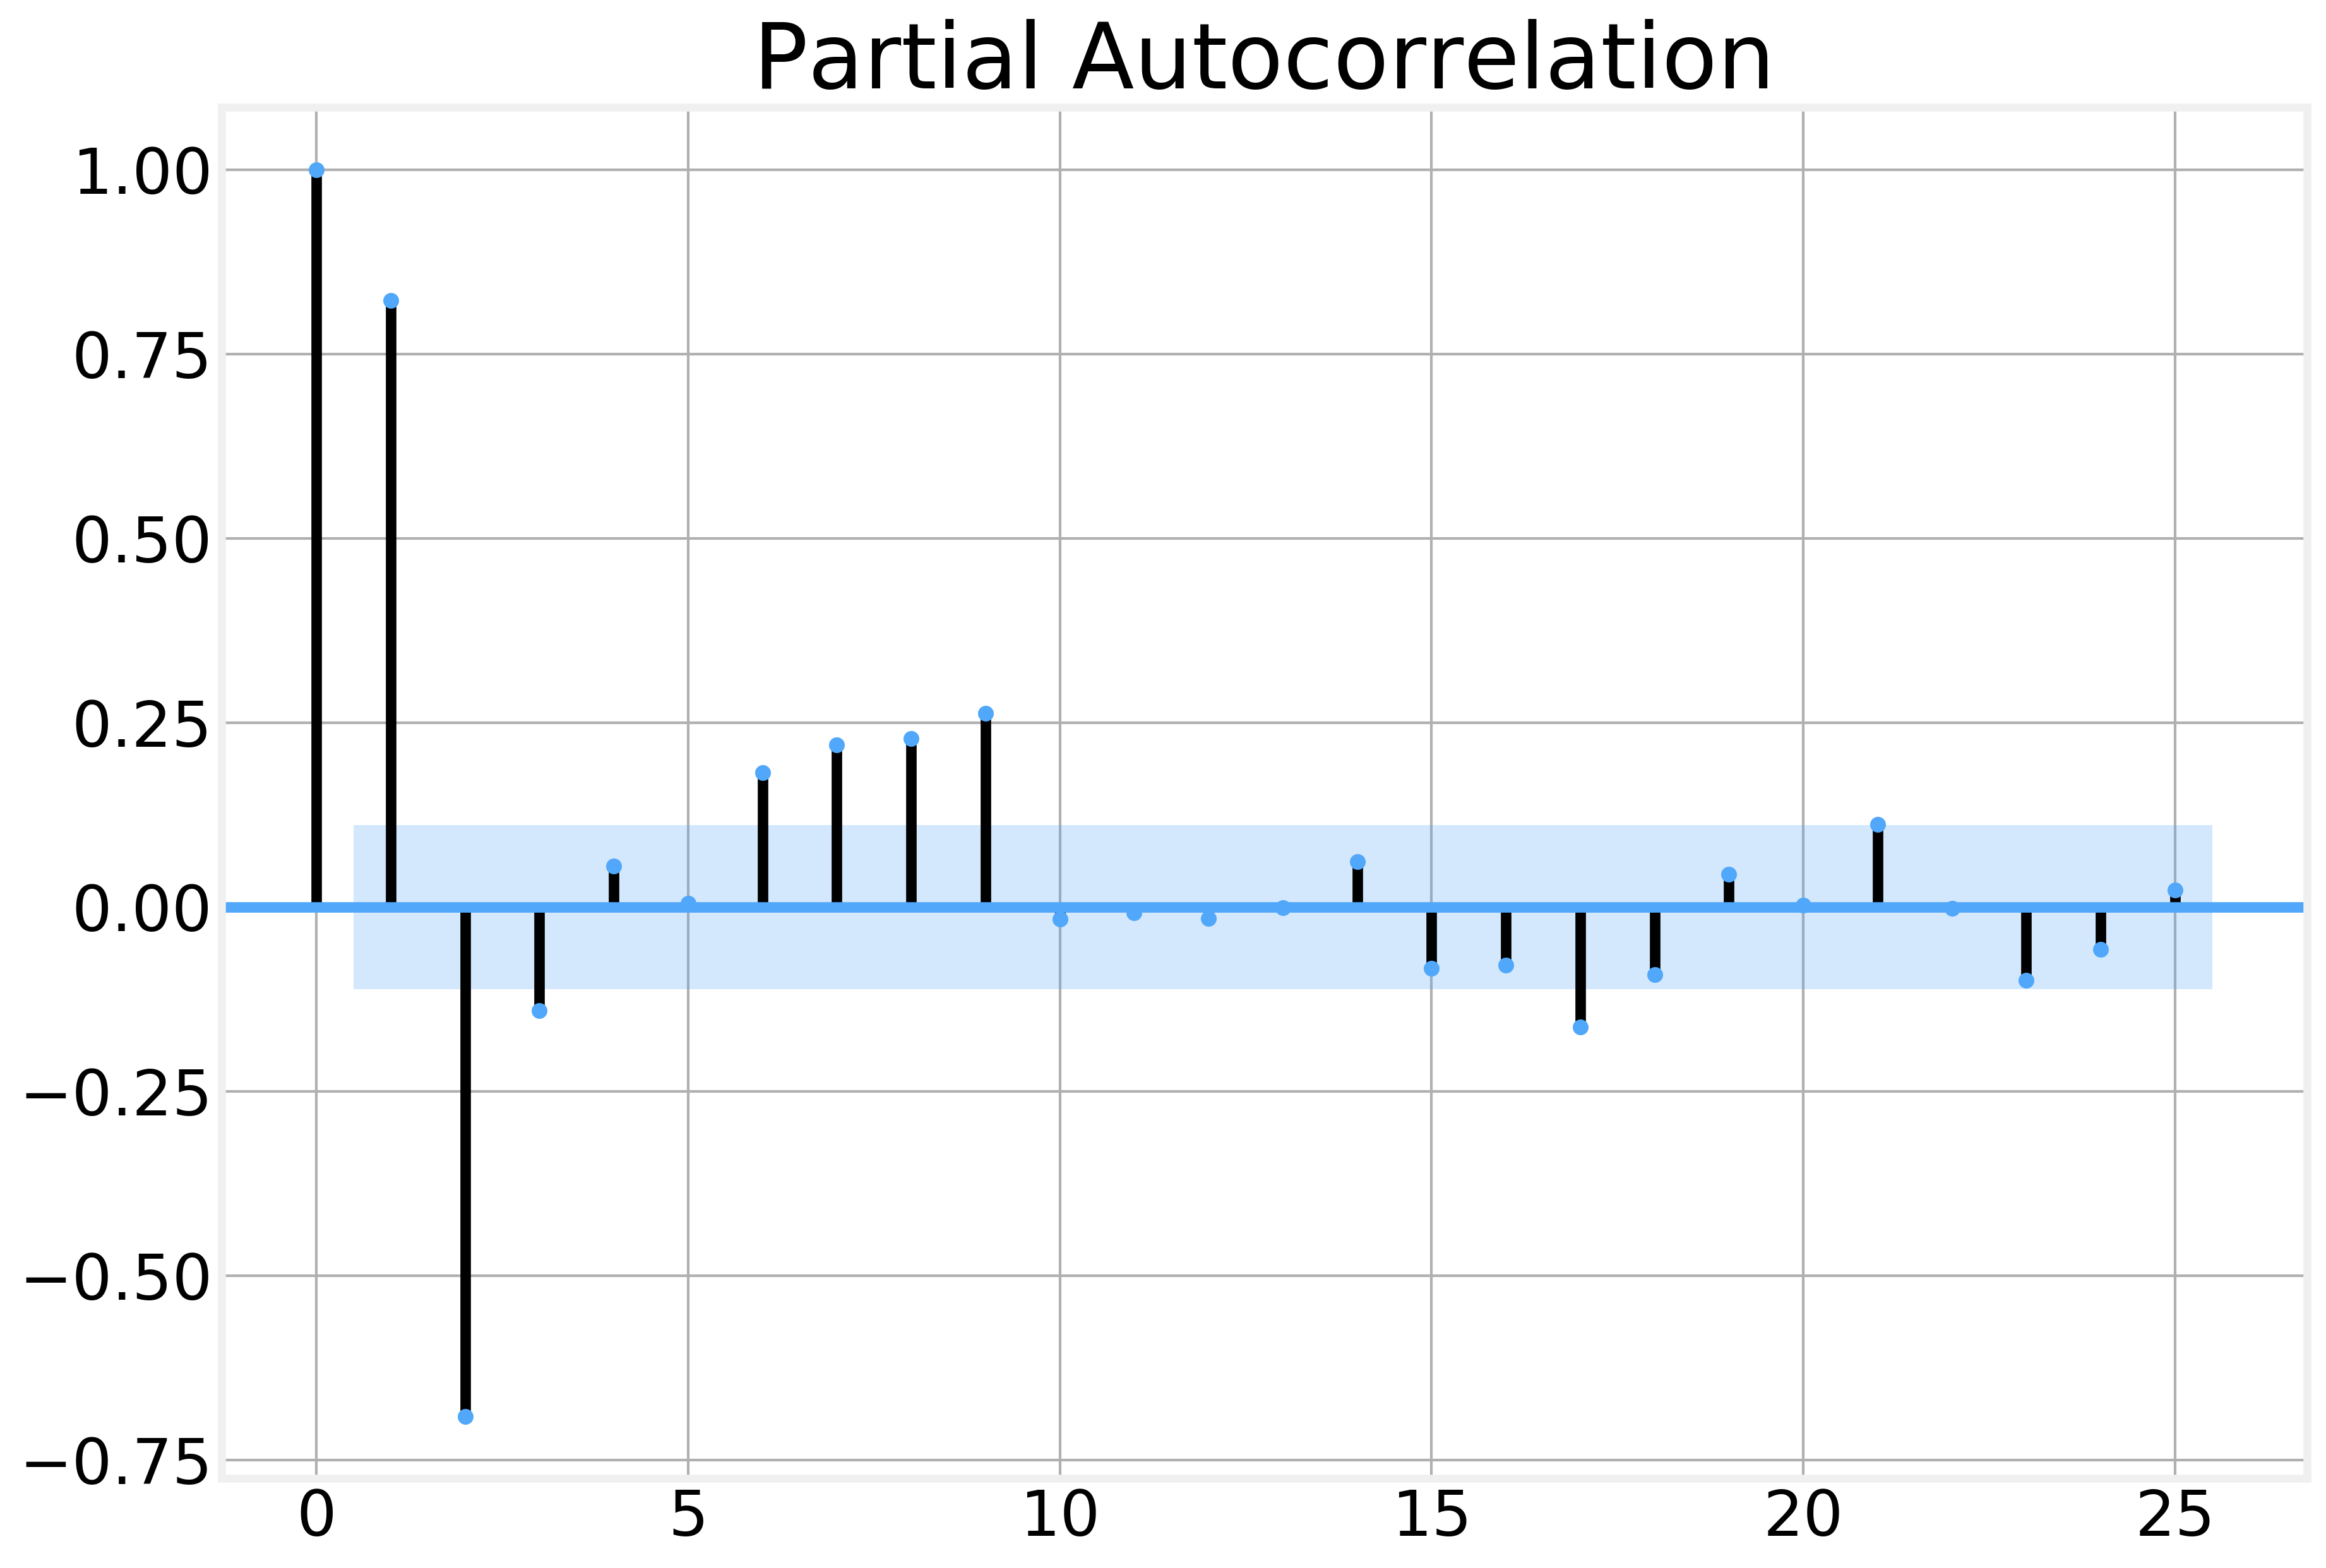

In [16]:
sm.graphics.tsa.plot_pacf(Sun['SUNACTIVITY']);

## Dickey-Fuller test

For this example, let's load the GDP dataset

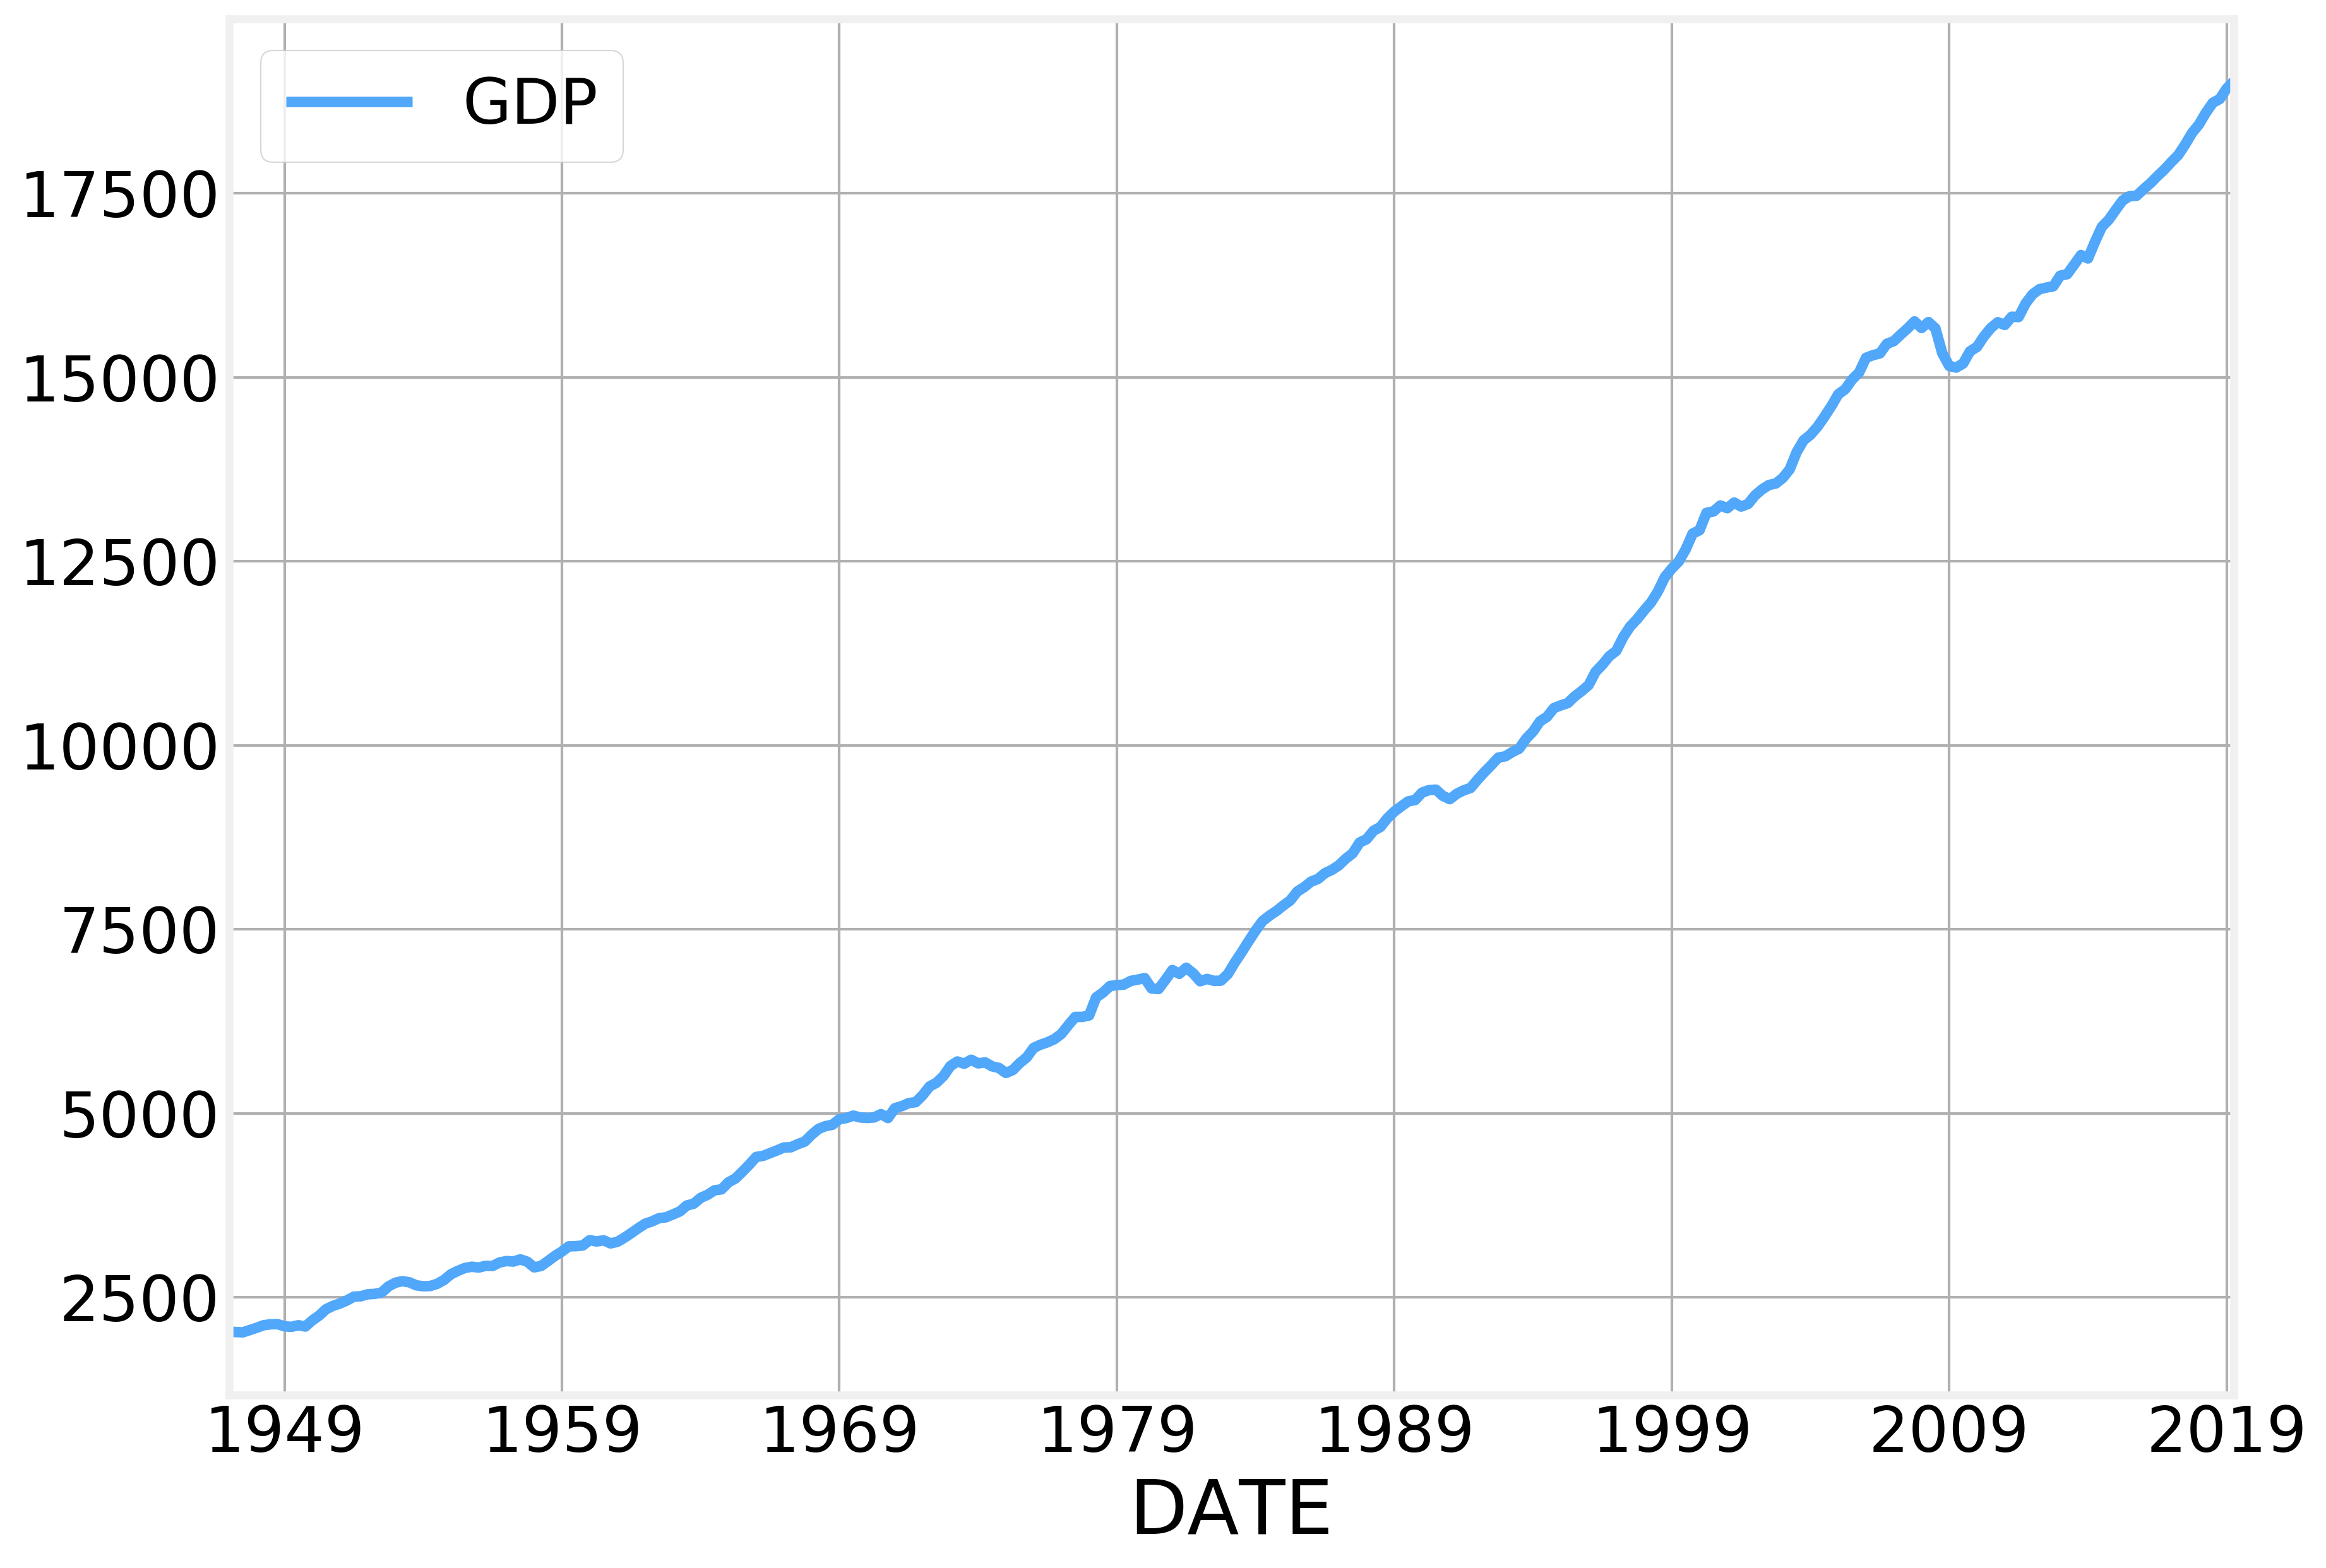

In [17]:
GDP = pd.read_csv('data/GDP.csv', parse_dates=['DATE'], index_col=[0])
GDP.plot()

If we run the Augmented Dickey-Fuller test for the original dataset we find

In [18]:
adf, pvalue, critical, results = sm.tsa.stattools.adfuller(GDP, regresults=True)

And in particular, the p-value makes it clear that the series is not stationary

In [19]:
pvalue

1.0

On the other hand, if we look instead at the QoQ values:

In [20]:
QoQ = GDP['GDP'].diff(1).dropna()
adf, pvalue, critical, results = sm.tsa.stattools.adfuller(QoQ, regresults=True)

We find a clearly significant result

In [21]:
pvalue

0.0009325178905257833

Or for a more complete overview:

In [22]:
print('ADF Statistic:', adf)
print('p-value:', pvalue)
print('Critical Values:')

for key, value in critical.items():
    print('\t%s:'% key, value)

ADF Statistic: -4.109942087089415
p-value: 0.0009325178905257833
Critical Values:
	1%: -3.4541800885158525
	5%: -2.872031361137725
	10%: -2.5723603999791473


We also obtain a lot more information in the __results__ object, like the number of lags used, how many total lags were tested, etc. In particullar

In [23]:
print(results)
print()
for key, value in results.__dict__.items():
    if not key.startswith("_") and key not in ("resols", "critvalues", "autolag_results"):
        print("%s: %s" % (key, value))
    elif key == "critvalues":
        print("%s:" % key)
        for key2, critical_value in value.items():
            print("\t%s:" % key2, critical_value )

Augmented Dickey-Fuller Test Results

maxlag: 16
usedlag: 11
adfstat: -4.109942087089415
critvalues:
	1%: -3.4541800885158525
	5%: -2.872031361137725
	10%: -2.5723603999791473
nobs: 277
H0: The coefficient on the lagged level equals 1 - unit root
HA: The coefficient on the lagged level < 1 - stationary
icbest: 3025.166829576211


And the full results of the OLS linear regression:

In [24]:
results.resols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     13.16
Date:                Wed, 12 Aug 2020   Prob (F-statistic):           3.89e-21
Time:                        07:38:13   Log-Likelihood:                -1524.9
No. Observations:                 277   AIC:                             3076.
Df Residuals:                     264   BIC:                             3123.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4325      0.105     -4.110      0.000      -0.640      -0.225
x2            -0.2529      0.109     -2.326      0.021      -0.467      -0.039
x3            -0.0278      0.109     -0.256      0.798      -0.242       0.186
x4            -0.0055      0.106     -0.052      0.959      -0.215       0.204
x5            -0.0105      0.100     -0.105      0.917      -0.208       0.187
x6            -0.0613      0.097     -0.634      0.527      -0.252       0.129
x7             0.0228      0.093      0.244      0.807      -0.161       0.206
x8             0.0006      0.088      0.007      0.995      -0.173       0.174
x9            -0.1256      0.083     -1.507      0.133      -0.290       0.039
x10            0.0551      0.079      0.698      0.486      -0.100       0.211
x11            0.1870      0.074      2.539      0.012       0.042       0.332
x12            0.1049      0.061      1.707      0.089      -0.016       0.226
const         26.4032      7.156      3.689      0.000      12.312      40.494
==============================================================================
Omnibus:                       32.007   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.856
Skew:                          -0.420   Prob(JB):                     6.26e-24
Kurtosis:                       5.925   Cond. No.                         213.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As well as the results for each of the lags considered:

In [25]:
results.autolag_results

{2: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff1ec12e240>,
 3: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff1ec12e668>,
 4: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff1ec12e358>,
 5: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff1ec12e2b0>,
 6: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff1ec12e0f0>,
 7: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff1ec12eb70>,
 8: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff1ec12ea90>,
 9: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff1ec12e5f8>,
 10: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff1ec12e710>,
 11: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff1ec12e5c0>,
 12: <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff1ec12e320>,
 13: <statsmodels.regression.linear_model.Regressio

## Times series decomposition

To illustrate the time series decomposition functionality of __statsmodels__, we're going to use the airline passengers dataset

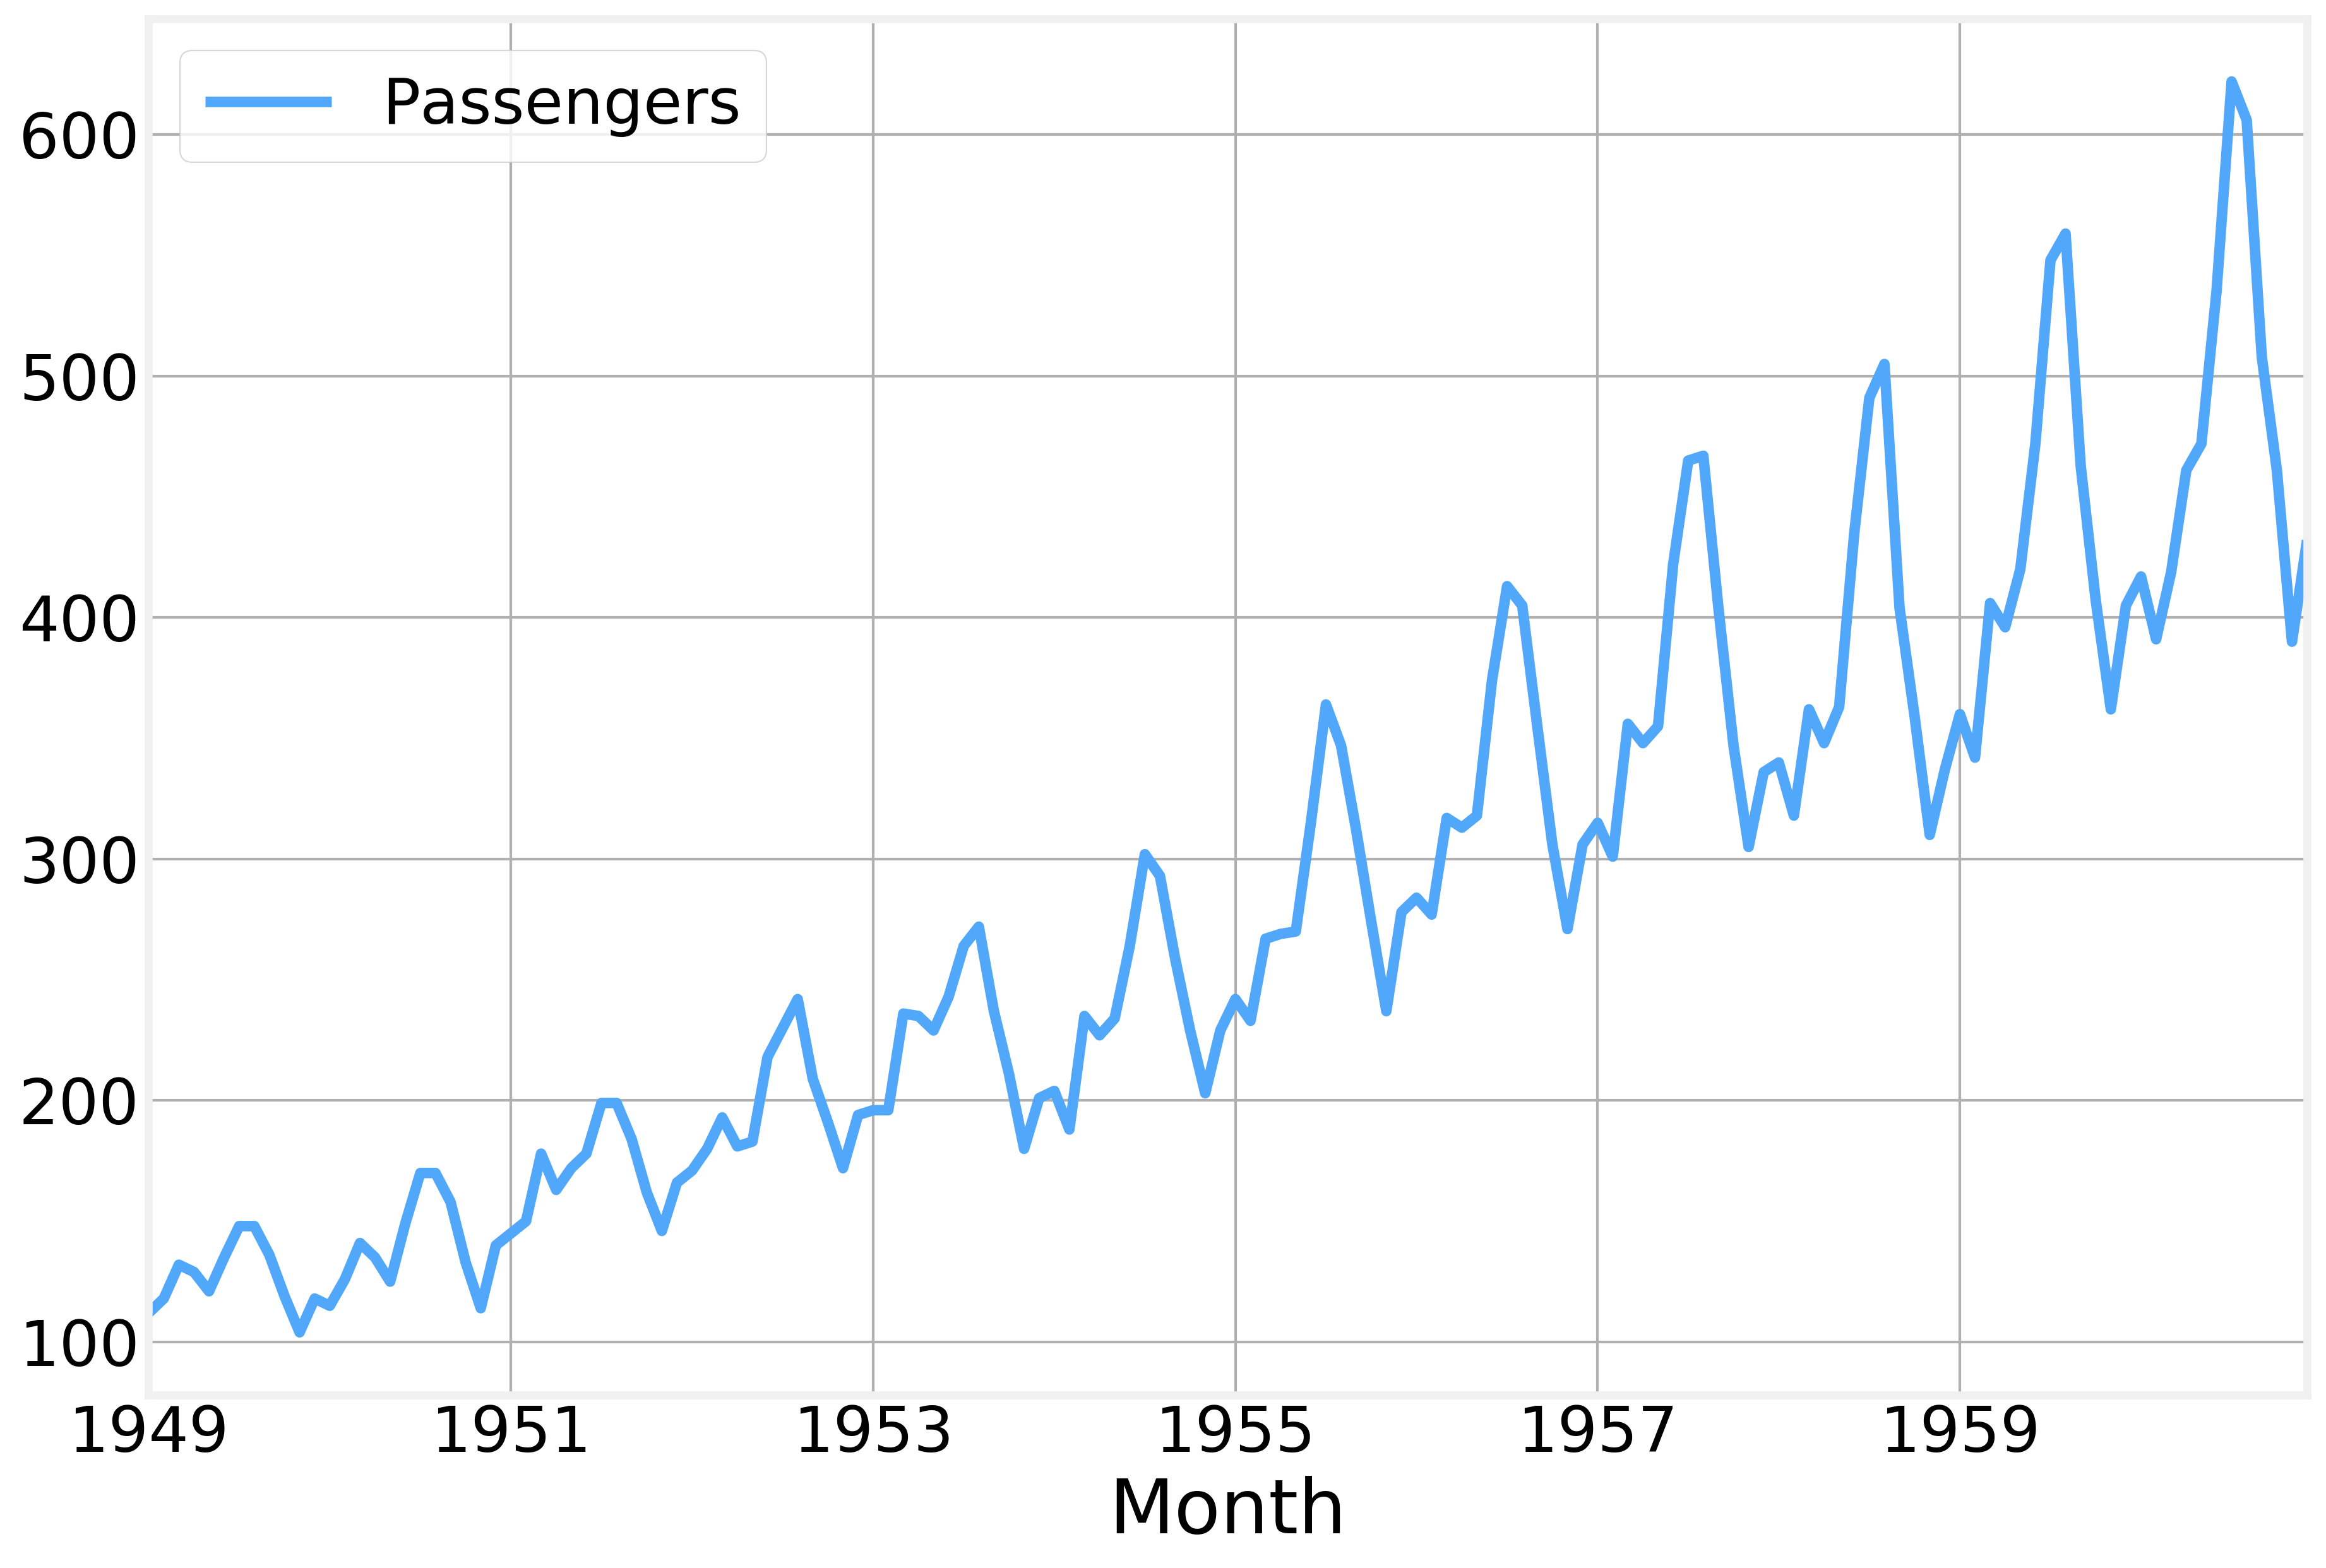

In [26]:
airline = pd.read_csv('data/international-airline-passengers.csv', sep=';', parse_dates=['Month'], index_col=0)
airline.plot()

To obtain the decomposition we must simply do:

In [27]:
decomposition = sm.tsa.seasonal_decompose(airline, model='multiplicative', two_sided=False)

We can quickly plot the usual decomposition visualization

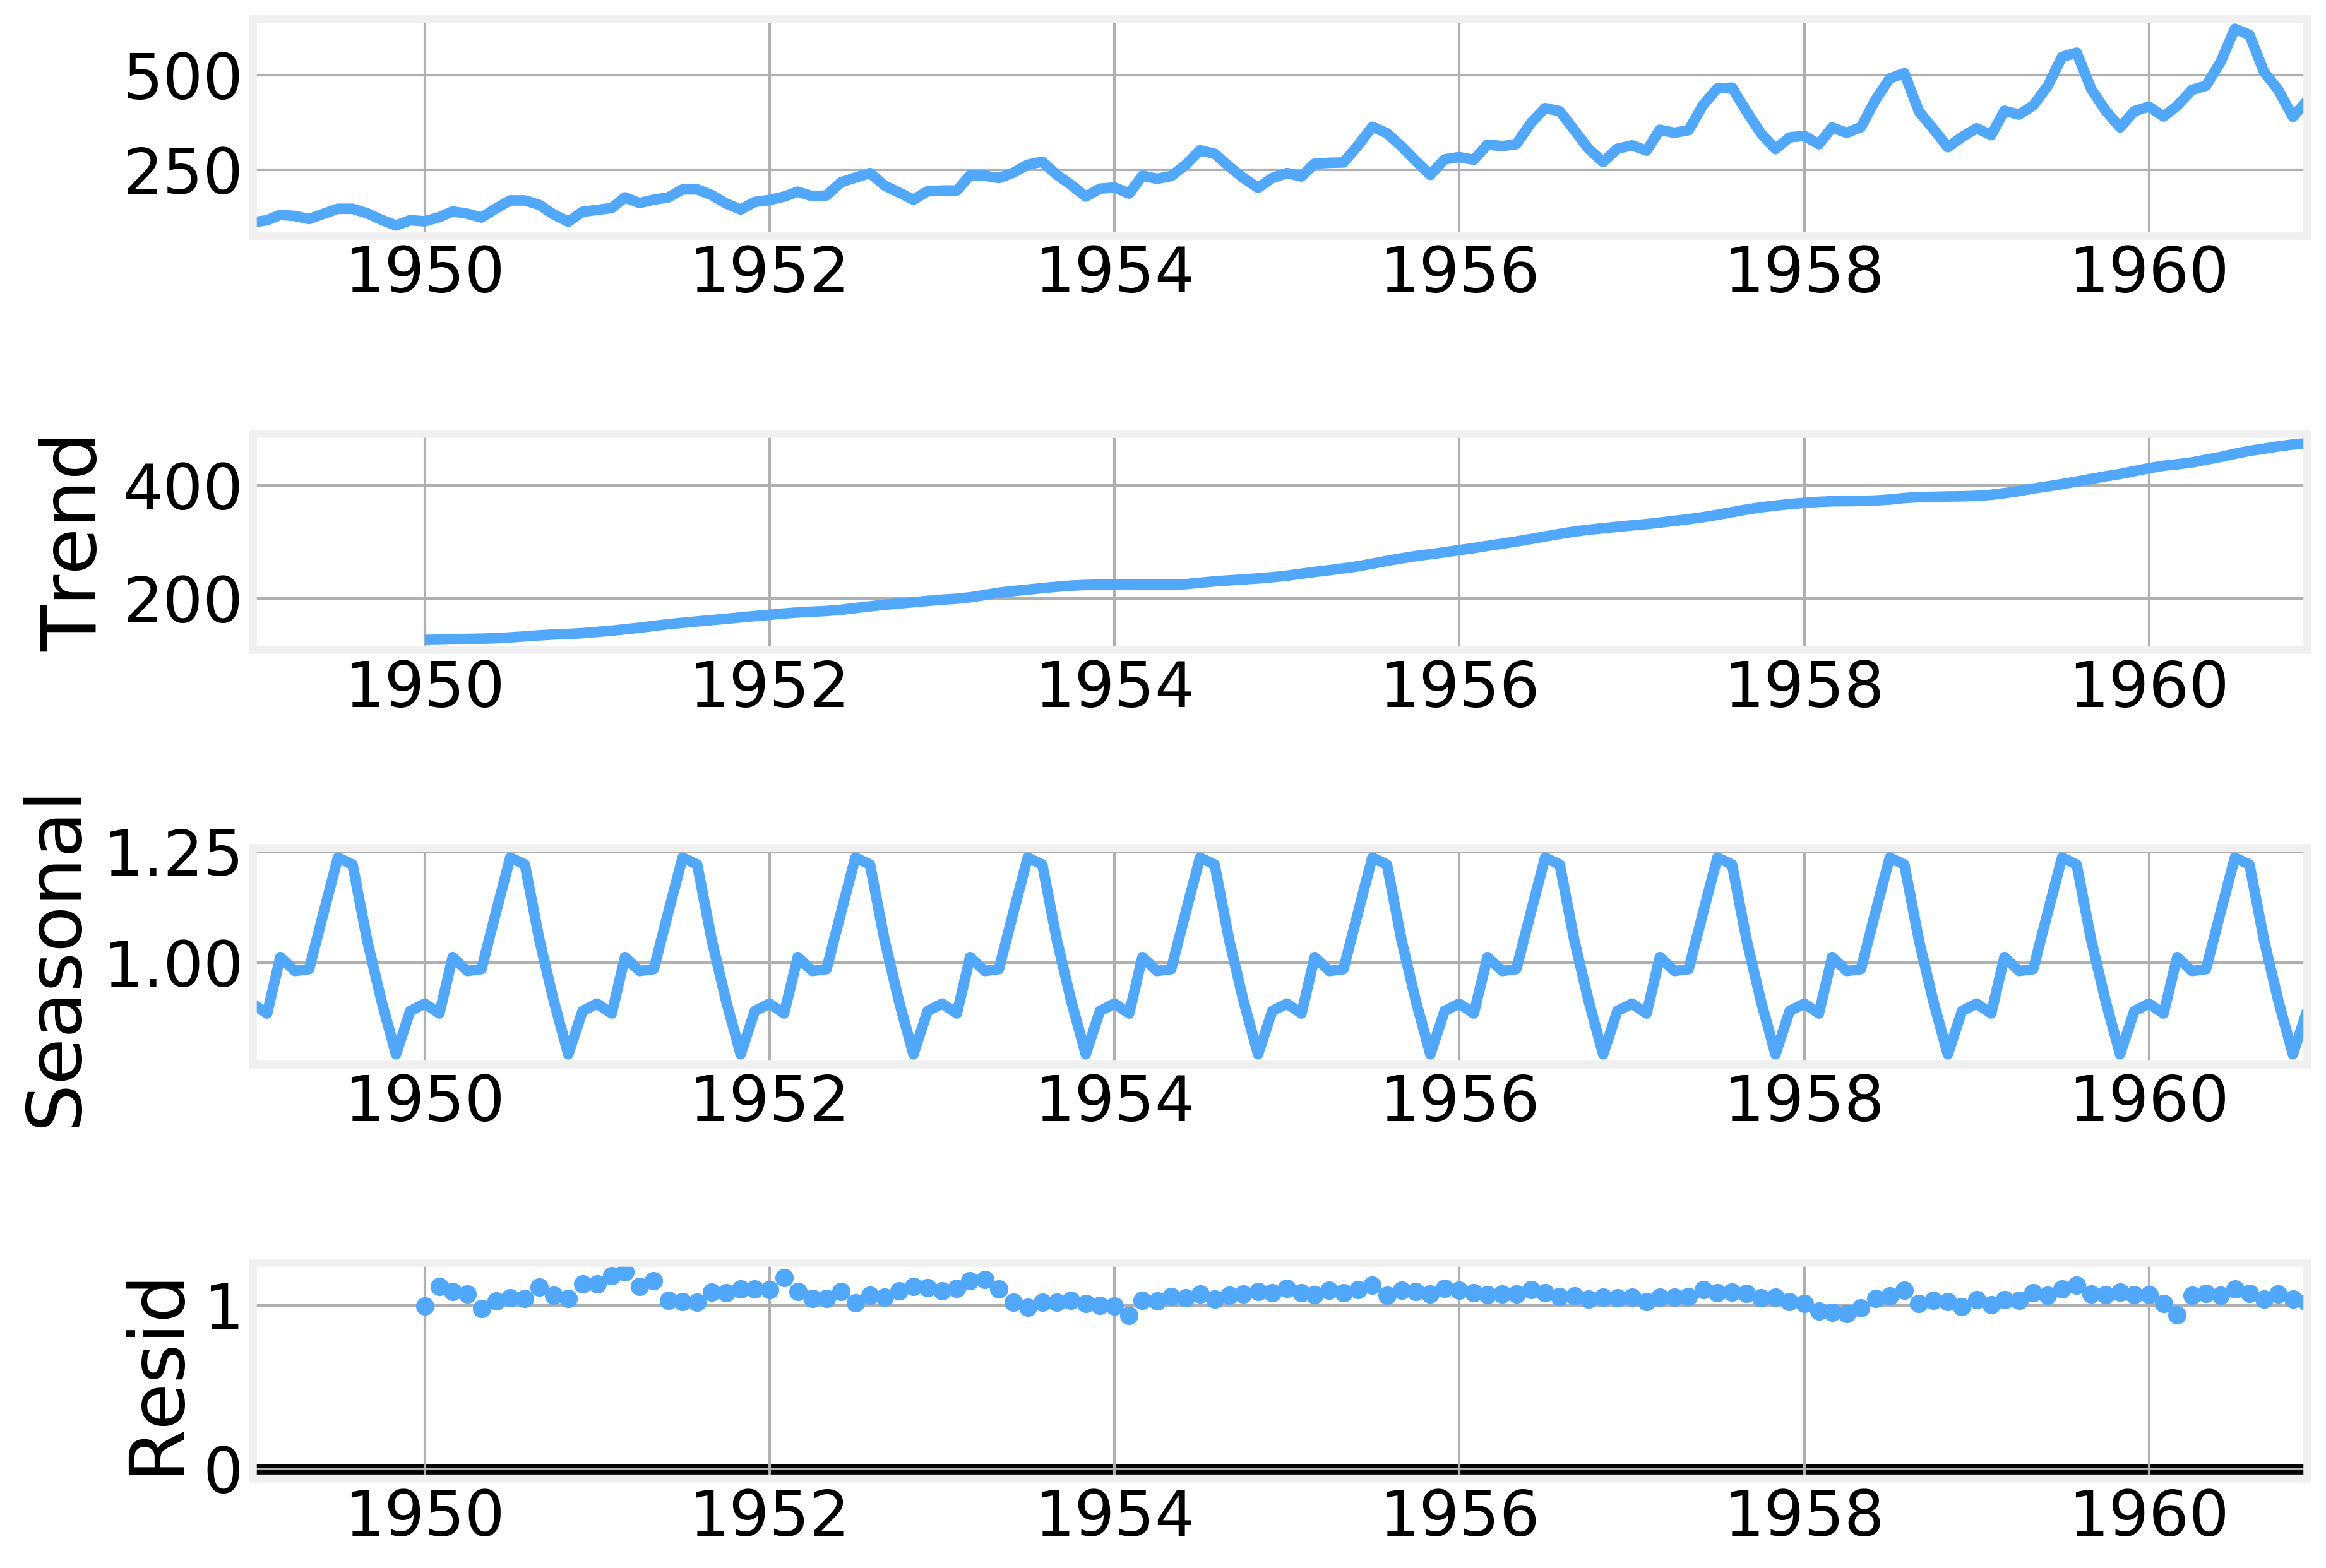

In [28]:
decomposition.plot();

Each of the components is provided as a separate pandas Series for easy access and analysis

In [29]:
decomposition.resid.tail()

Month
1960-08-01    1.075368
1960-09-01    1.039580
1960-10-01    1.073172
1960-11-01    1.038786
1960-12-01    1.019882
Name: resid, dtype: float64

And, of course, visualization

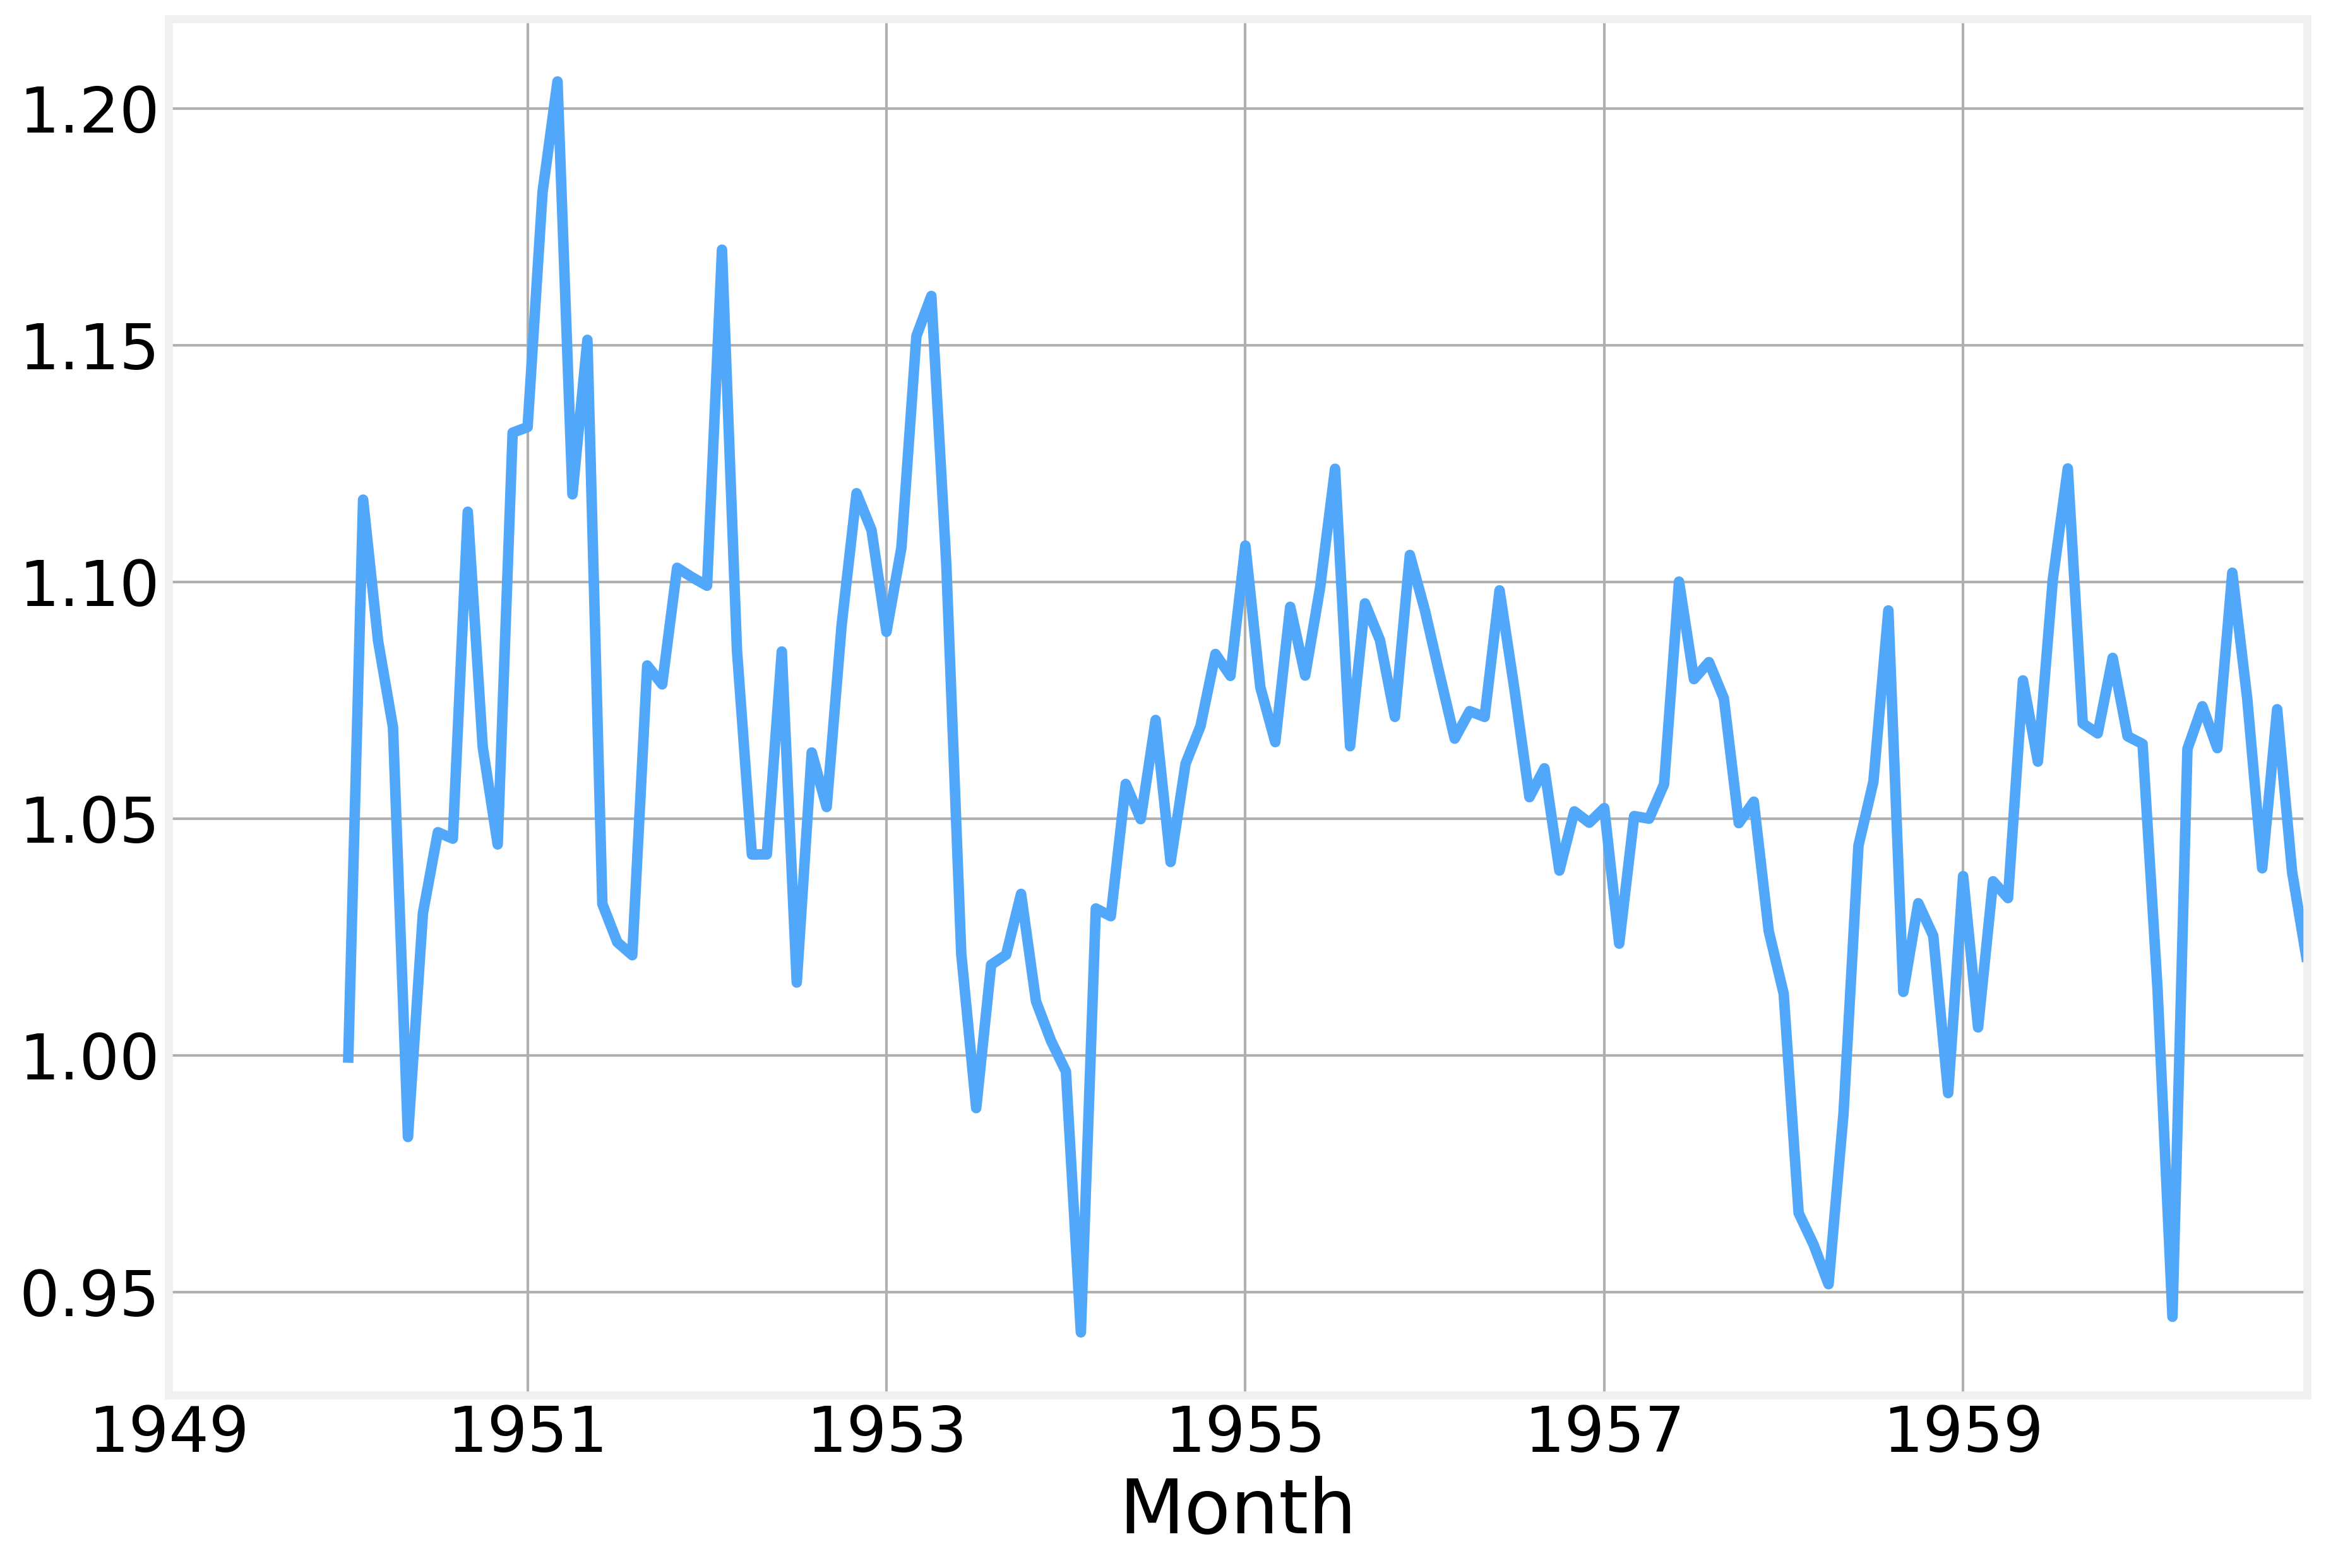

In [30]:
decomposition.resid.plot()

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>